In [1]:
#coding:utf-8
import pandas as pd
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from ncov.reader import get_data,watch_data
## test:
# get_data('湖北', '武汉', '2020-01-01', '2020-02-08')

,time,city,new_confirmed,new_death,new_recovered,accumulated_confirmed,accumulated_death,accumulated_recovered,new_suspected,accumulated_suspected,accumulated_close_contact,accumulated_quit_medical_observation,under_medical_observation
0,2020-01-10,武汉,41,1,2,41,1,2,None,None,None,None,None
1,2020-01-11,武汉,0,0,4,41,1,6,None,None,None,None,None
2,2020-01-12,武汉,0,0,1,41,1,7,None,None,None,None,None
3,2020-01-13,武汉,0,0,1,41,1,7,None,None,None,None,None
4,2020-01-14,武汉,0,0,1,41,1,7,None,None,None,None,None
5,2020-01-15,武汉,0,1,5,41,2,12,None,None,None,None,None
6,2020-01-16,武汉,4,0,3,45,2,15,None,None,None,None,None
7,2020-01-17,武汉,17,0,4,62,2,19,None,None,None,None,None
8,2020-01-18,武汉,59,1,5,121,3,24,None,None,None,None,None
9,2020-01-19,武汉,77,0,1,198,3,25,None,None,None,None,None


In [6]:
import torch
from torch.nn.parameter import Parameter
torch.set_default_tensor_type(torch.DoubleTensor)

In [137]:
class SEIR_cell(torch.nn.Module):
    def __init__(self, N, beta_init, gamma_2_init, theta_init):
        super(SEIR_cell, self).__init__()
        # self.date_len = date_len
        self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        self.N = Parameter(torch.tensor([N], requires_grad=True))
        self.gamma_1 = 0.
        self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        self.alpha = 1.
        self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
        # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))


    def clamp(self, X):
        # return torch.clamp(X, min=0, max=self.N)
        return X

    def forward(self, X):
        S, confirm, Exposed, recover, dead = X
        # self.beta = beta_old + self.beta_add
        # self.gamma_2 = gamma_2_old + self.gamma_2_add
        S_rest = self.clamp(S - self.beta*confirm*S/self.N) # dS/dt
        E = self.clamp(Exposed + self.beta*confirm*S/self.N - self.alpha*Exposed) # dE/dt

        # I = self.clamp(confirm + self.alpha*Exposed - self.gamma_2*confirm - self.theta*confirm) # dI/dt
        # R = self.clamp(recover + self.gamma_2*confirm) # dR/dt
        # D = self.clamp(dead + self.theta*confirm)
        I = self.clamp(confirm + self.alpha*E - self.gamma_2*confirm - self.theta*confirm) # dI/dt
        R = self.clamp(recover + self.gamma_2*I) # dR/dt
        D = self.clamp(dead + self.theta*I)

        return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.N


In [138]:

class SEIR_model(torch.nn.Module):
    def __init__(self, date_len, pred_date_len=0, N=2870000., beta_init=0.2586,  gamma_2_init=0.018, theta_init=0.001, E_ratio_init=3., I_init=41, R_init=2., D_init=0.):
        super(SEIR_model, self).__init__()
        self.date_len = date_len
        self.SEIR_cells = torch.nn.ModuleList()
        self.SEIR_pred_cells = torch.nn.ModuleList()
        self.N = N
        self.E_ratio = E_ratio_init
        # self.I = (1e-6)*self.N
        # self.E = (self.I * self.E_ratio)
        # self.R = (1e-6 / 2)*self.N
        # self.S = (self.N - self.I - self.E - self.R)
        # self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        # self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        self.beta = beta_init
        self.gamma_2 = gamma_2_init
        self.theta = theta_init
        self.I = I_init
        self.E = (self.I * self.E_ratio)
        self.R = R_init
        self.D = D_init
        self.S = (self.N - self.I - self.E - self.R - self.D)
        self.date_len = date_len-1
        self.pred_date_len = pred_date_len
        # self.date_total_len = self.date_len + self.pred_date_len
        for i in range(self.date_len):
            self.SEIR_cells.append(SEIR_cell(self.N,self.beta,self.gamma_2, self.theta))

        self.S_tensor_cur = torch.zeros((self.date_len+1,))
        self.I_tensor_cur = torch.zeros((self.date_len+1,))
        self.E_tensor_cur = torch.zeros((self.date_len+1,))
        self.R_tensor_cur = torch.zeros((self.date_len+1,))
        self.D_tensor_cur = torch.zeros((self.date_len+1,))
        
    
    def forward(self, X):
        inp = self.S, self.I, self.E, self.R, self.D
        # param = beta_init, gamma_2_init
        S_tensor = torch.zeros((self.date_len+1,))
        I_tensor = torch.zeros((self.date_len+1,))
        E_tensor = torch.zeros((self.date_len+1,))
        R_tensor = torch.zeros((self.date_len+1,))
        D_tensor = torch.zeros((self.date_len+1,))
        S_tensor[0], I_tensor[0], E_tensor[0], R_tensor[0], D_tensor[0] = inp
        for i in range(self.date_len):
            S, I, E, R, D, beta_cur, gamma_2_cur, theta_cur, N = self.SEIR_cells[i](inp)
            S_tensor[i+1], I_tensor[i+1], E_tensor[i+1], R_tensor[i+1], D_tensor[i+1] = S, I, E, R, D
            self.beta = beta_cur
            self.gamma_2 = gamma_2_cur
            self.theta = theta_cur
            self.S_cur = S
            self.I_cur = I
            self.E_cur = E
            self.R_cur = R
            self.D_cur = D
            self.N_cur = N
            inp = [S, I, E, R, D]
        self.S_tensor_cur, self.I_tensor_cur, self.E_tensor_cur, self.R_tensor_cur, self.D_tensor_cur = S_tensor, I_tensor, E_tensor, R_tensor, D_tensor
        return S_tensor, I_tensor, E_tensor, R_tensor, D_tensor, beta_cur, gamma_2_cur

    def pred(self, pred_date_len):
        cur_pred_cells_len = len(self.SEIR_pred_cells)
        # print("cur_pred_cells_len:", cur_pred_cells_len)
        if cur_pred_cells_len!=pred_date_len:
            self.SEIR_pred_cells = torch.nn.ModuleList()
            for i in range(pred_date_len):
                self.SEIR_pred_cells.append(SEIR_cell(self.N_cur,self.beta,self.gamma_2,self.theta))
        S_pred_tensor = torch.zeros((pred_date_len,))
        I_pred_tensor = torch.zeros((pred_date_len,))
        E_pred_tensor = torch.zeros((pred_date_len,))
        R_pred_tensor = torch.zeros((pred_date_len,))
        D_pred_tensor = torch.zeros((pred_date_len,))
        # pred:
        inp = self.S_cur, self.I_cur, self.E_cur, self.R_cur, self.D_cur
        for i in range(pred_date_len):
            S, I, E, R, D, beta_, gamma_2_, theta_, N_ = self.SEIR_pred_cells[i](inp)
            S_pred_tensor[i], I_pred_tensor[i], E_pred_tensor[i], R_pred_tensor[i], D_pred_tensor[i] = S, I, E, R, D
            inp = [S, I, E, R, D]
        return S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor
    
        

In [189]:
def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    T_name = 'time'
    plt.figure(figsize=(xlen, 6))
    # accumulated_confirmed = data[I_name]
    # accumulated_death = data['accumulated_death']
    # accumulated_recovered = data[R_name]
    time_val = data[T_name].values
    
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, accumulated_confirmed, color = 'red', label = '累计确诊人数',marker = 'x')
    plt.plot(merge_time, accumulated_pred_confirmed, color = 'blue',label = '预测的累计确诊人数',marker = 'x')
    # plt.plot(accumulated_death, color = 'gray',label = '累计死亡人数',marker = 'x')
    # plt.plot(time_val, accumulated_recovered, color = 'green', label = '累计治愈人数',marker = '.')
    # plt.plot(merge_time, pred_R, color = 'black', label = '预测的累计治愈人数',marker = '.')
    # plt.plot(RES[:,2],color = 'orange',label = 'The Exposed',marker = '.')
    # plt.plot(RES[:,3],color = 'green',label = 'The Recovered',marker = '.')
    # for a, b in zip(merge_time, pred_I):
    #     plt.text(a, b+0.3, b, ha='center', va='bottom', fontsize=12, color='blue')
    # for a, b in zip(time_val, accumulated_confirmed):
    #     plt.text(a, b-10, b, ha='center', va='bottom', fontsize=12, color='red')
    for a,b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

In [157]:
def plot_daily_new(data, new_confirm, pred_new_confirm, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, new_confirm, color = 'red', label = '新增确诊人数',marker = 'x')
    plt.plot(merge_time, pred_new_confirm, color = 'blue',label = '新增累计确诊人数',marker = 'x')
    # plt.plot(accumulated_death, color = 'gray',label = '累计死亡人数',marker = 'x')
    # plt.plot(time_val, accumulated_recovered, color = 'green', label = '累计治愈人数',marker = '.')
    # plt.plot(merge_time, pred_R, color = 'black', label = '预测的累计治愈人数',marker = '.')
    # plt.plot(RES[:,2],color = 'orange',label = 'The Exposed',marker = '.')
    # plt.plot(RES[:,3],color = 'green',label = 'The Recovered',marker = '.')
    # for a, b in zip(merge_time, pred_I):
    #     plt.text(a, b+0.3, b, ha='center', va='bottom', fontsize=12, color='blue')
    # for a, b in zip(time_val, accumulated_confirmed):
    #     plt.text(a, b-10, b, ha='center', va='bottom', fontsize=12, color='red')
    for a,b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

In [140]:
import torch.optim as optim
import os
# def loss_fn(pred, gt):
#     T = gt.shape
#     loss = torch.tensor([0.])
#     for i in range(T.data.numpy()):
#         loss = loss + torch.mean((i+1)*torch.pow(pred[i]-gt[i],2))
    # return loss
def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path,city)
    
    model_city_date_path = os.path.join(model_city_path,date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path

def train(data, model_city_date_path, N=1e7, I_init=1e-6, R_init=1e-6/2., D_init=1e-6/6., features=['accumulated_confirmed', 'accumulated_recovered', 'accumulated_death'], max_epoches = 400):
    model_pt = os.path.join(model_city_date_path,'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat,dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len,  pred_date_len = 10, N=N, I_init=I_init, R_init=R_init, D_init=D_init)
    # Learning rate for optimizers
    lr = 0.01
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    # I_pred_list = []
    # R_pred_list = []
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    loss_min = 1e8
    for step in range(max_epoches):
        print("Training step: ", step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S,I,E,R,D, beta,gamma_2 = model(model_inp.float())
        # print(output)
        loss_fn = torch.nn.MSELoss()
        pred_confirmed = I
        pred_recovered = R
        pred_dead = D
        # print(pred_confirmed)
        
        confirmed_gt_tensor = Input[:,0]
        recovered_gt_tensor = Input[:,1]
        dead_gt_tensor = Input[:,2]
        # print(recovered_gt_tensor)
        # print(pred_confirmed.shape)
        # loss = loss_fn(pred_confirmed,confirmed_gt_tensor)
        loss = loss_fn(pred_confirmed, confirmed_gt_tensor) + loss_fn(pred_recovered, recovered_gt_tensor) + loss_fn(pred_dead, dead_gt_tensor)
        print("Loss: {}".format(loss))
        if loss<loss_min:
            loss_min = loss
            torch.save(model, model_pt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:",loss_min)
    return S,I,E,R,D


# model_city_date_path = make_dir('wuhan','02-03')
# features=['accumulated_confirmed', 'accumulated_recovered']
# S,I,E,R,model = train(data_wh_feat, model_city_date_path, N=2870000., I_init=41, R_init=2., features=features, max_epoches=400)

In [258]:
def load_model_predict(model_city_date_path, data, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(confirm_origin)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)


    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)
    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total

    plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

In [254]:
# data_china = pd.read_excel('./ncov/data/nation_data.xlsx')
data_china = pd.read_csv('./ncov/data/nation/nation.csv')
data_china

,time,accumulated_close_contact,under_medical_observation,accumulated_quit_medical_observation,accumulated_confirmed,accumulated_suspected,accumulated_death,accumulated_cured,new_confirmed,new_suspected,new_death,new_cured
0,1月20日,1739,922,817,291,54,6,0,77,27,6,0
1,1月21日,2197,1349,765,440,136,9,0,149,82,3,0
2,1月22日,5897,4928,969,571,393,17,0,131,257,8,0
3,1月23日,9507,8420,1087,830,1072,25,34,259,680,8,6
4,1月24日,15197,13967,1230,1287,1965,41,38,444,1118,16,3
5,1月25日,23431,21556,1555,1975,2684,56,49,688,1309,15,11
6,1月26日,32799,30453,2138,2744,5794,80,51,769,3806,24,2
7,1月27日,47833,44132,3052,4515,6973,106,60,1771,2077,26,9
8,1月28日,65537,59990,4656,5974,9239,132,103,1459,3248,26,43
9,1月29日,88693,81947,7020,7711,12167,170,124,1737,4148,38,21


In [255]:
data_china['time'] = data_china['time'].apply(lambda x: '2020/'+x.replace('月','/').replace('日',''))
data_china['time'] = pd.to_datetime(data_china['time'])

In [242]:
data_china['accumulated_confirmed']

0       291
1       440
2       571
3       830
4      1287
5      1975
6      2744
7      4515
8      5974
9      7711
10     9692
11    11791
12    14380
13    17205
14    20438
15    24324
16    28018
17    31161
18    34546
19    37198
Name: accumulated_confirmed, dtype: int64

In [244]:
model_city_date_path = make_dir('china','02-08')
features=['accumulated_confirmed', 'accumulated_cured', 'accumulated_death']
I_init = float(data_china['accumulated_confirmed'].iloc[0])
R_init = float(data_china['accumulated_cured'].iloc[0])
D_init = float(data_china['accumulated_death'].iloc[0])
N = 13000000000.
S_china,I_china,E_china,R_china,D_china = train(data_china, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

2414418121
Training step:  1564
Loss: 1452304.8843124765
Training step:  1565
Loss: 1133069.4465833749
Training step:  1566
Loss: 1452268.2263324703
Training step:  1567
Loss: 1133032.7458702237
Training step:  1568
Loss: 1452231.6619625932
Training step:  1569
Loss: 1132996.1389615173
Training step:  1570
Loss: 1452195.190865299
Training step:  1571
Loss: 1132959.6255180363
Training step:  1572
Loss: 1452158.8127040456
Training step:  1573
Loss: 1132923.2052020908
Training step:  1574
Loss: 1452122.5271441161
Training step:  1575
Loss: 1132886.877677651
Training step:  1576
Loss: 1452086.3338521894
Training step:  1577
Loss: 1132850.6426102198
Training step:  1578
Loss: 1452050.2324967082
Training step:  1579
Loss: 1132814.49966692
Training step:  1580
Loss: 1452014.222747397
Training step:  1581
Loss: 1132778.4485163765
Training step:  1582
Loss: 1451978.3042758473
Training step:  1583
Loss: 1132742.4888291955
Training step:  1584
Loss: 1451942.476755621
Training step:  1585
Loss: 11

[  291   440   571   830  1287  1975  2744  4515  5974  7711  9692 11791
 14380 17205 20438 24324 28018 31161 34546 37198]


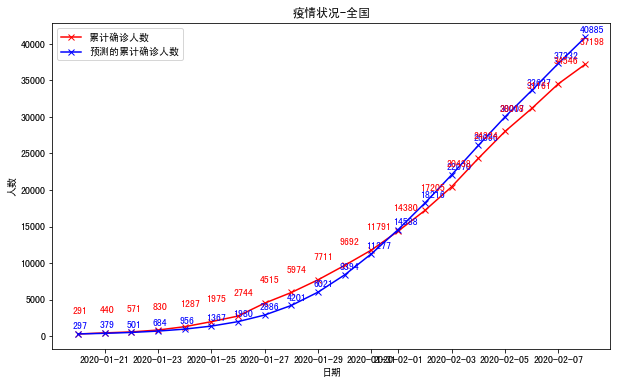

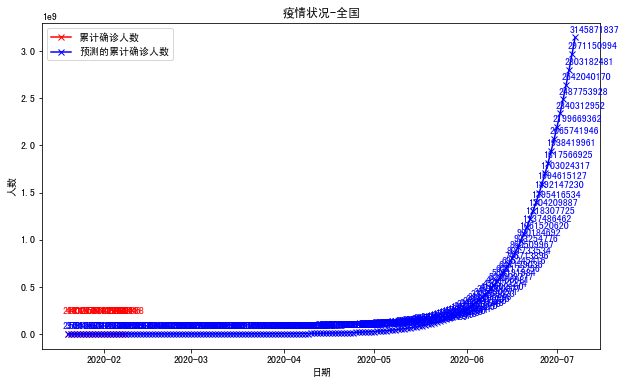

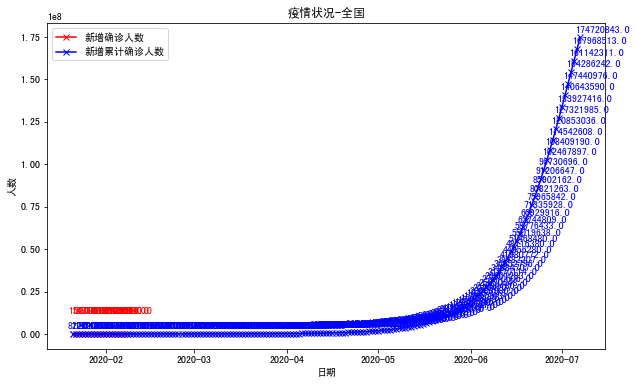

In [259]:
load_model_predict(model_city_date_path, data_china, city_name='全国',c='accumulated_confirmed',features=features,pred_date_len=150)

In [260]:
merge_data = pd.read_csv('./ncov/data/nation/allcity_20200209.csv')
merge_data = merge_data.rename(columns = {'updatetime':'time'})
merge_data['time'] = merge_data['time'].apply(lambda x: '2020/'+x)
merge_data['time']

0       2020/01/16
1       2020/01/17
2       2020/01/18
3       2020/01/19
4       2020/01/20
           ...    
6046    2020/02/05
6047    2020/02/06
6048    2020/02/07
6049    2020/02/08
6050    2020/02/09
Name: time, Length: 6051, dtype: object

In [261]:
merge_data['I'] = merge_data['confirmed']-merge_data['dead']-merge_data['cured']
merge_data['I']

0        43
1        60
2       118
3       194
4       239
       ... 
6046      1
6047      1
6048      1
6049      1
6050      1
Name: I, Length: 6051, dtype: int64

In [262]:
merge_data['time']= pd.to_datetime(merge_data['time'])
merge_data['time']

0      2020-01-16
1      2020-01-17
2      2020-01-18
3      2020-01-19
4      2020-01-20
          ...    
6046   2020-02-05
6047   2020-02-06
6048   2020-02-07
6049   2020-02-08
6050   2020-02-09
Name: time, Length: 6051, dtype: datetime64[ns]

In [263]:
data_sz = merge_data[merge_data.cityname=='深圳']
data_sz

,provinceid,provincename,cityid,cityname,confirmed,suspected,dead,cured,time,I
480,7,广东,129.0,深圳,31,0,0,2,2020-01-26,29
481,7,广东,129.0,深圳,36,0,0,3,2020-01-27,33
482,7,广东,129.0,深圳,57,0,0,4,2020-01-28,53
483,7,广东,129.0,深圳,80,0,0,4,2020-01-29,76
484,7,广东,129.0,深圳,98,0,0,4,2020-01-30,94
485,7,广东,129.0,深圳,134,0,0,4,2020-01-31,130
486,7,广东,129.0,深圳,170,0,0,5,2020-02-01,165
487,7,广东,129.0,深圳,207,0,0,5,2020-02-02,202
488,7,广东,129.0,深圳,245,0,0,10,2020-02-03,235
489,7,广东,129.0,深圳,271,0,0,13,2020-02-04,258


In [264]:
def cal_acc_confirm(I,R,D):
    return I+R+D
def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm
def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

In [265]:
model_city_date_path = make_dir('shenzhen','02-08')
features=['I', 'cured','dead']
I_init = float(data_sz['I'].iloc[0])
R_init = float(data_sz['cured'].iloc[0])
D_init = float(data_sz['dead'].iloc[0])
N = 13026600.
S,I,E,R,D = train(data_sz, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

725768581
Training step:  1560
Loss: 110.17137468682373
Training step:  1561
Loss: 91.5757115979892
Training step:  1562
Loss: 110.17029384352266
Training step:  1563
Loss: 91.57454796950974
Training step:  1564
Loss: 110.16921470636295
Training step:  1565
Loss: 91.5733863665758
Training step:  1566
Loss: 110.16813727132023
Training step:  1567
Loss: 91.57222678355102
Training step:  1568
Loss: 110.16706153438669
Training step:  1569
Loss: 91.57106921481648
Training step:  1570
Loss: 110.1659874915577
Training step:  1571
Loss: 91.5699136547734
Training step:  1572
Loss: 110.16491513883308
Training step:  1573
Loss: 91.5687600978306
Training step:  1574
Loss: 110.16384447221873
Training step:  1575
Loss: 91.56760853844713
Training step:  1576
Loss: 110.16277548778811
Training step:  1577
Loss: 91.56645897110822
Training step:  1578
Loss: 110.16170818158311
Training step:  1579
Loss: 91.5653113903053
Training step:  1580
Loss: 110.1606425496831
Training step:  1581
Loss: 91.56416579056

In [223]:
# def load_model_predict(model_city_date_path, data, city_name='深圳',c='confirmed'):
#     model_pt = os.path.join(model_city_date_path,'model.pt')
#     model = torch.load(model_pt)
#     I = model.I_tensor_cur
#     R = model.R_tensor_cur
#     D = model.D_tensor_cur
#     I_pred_old = (I.detach().numpy()).astype(np.int)
#     R_pred_old = (R.detach().numpy()).astype(np.int)
#     D_pred_old = (D.detach().numpy()).astype(np.int)

#     confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     print(confirm_origin)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)


#     new_confirm = cal_new_confirm(np.array(data['I']),np.array(data['cured']),np.array(data['dead']))
#     cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
#     new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

#     S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = 5)
#     I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
#     R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
#     D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
#     I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
#     R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
#     D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

#     confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
#     confirm_origin = get_data_acc_confirm(data,c=c)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=5)

#     new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
#     new_confirm_pred_total

#     plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=5)

In [266]:
model_city_date_path

'models/shenzhen/02-08'

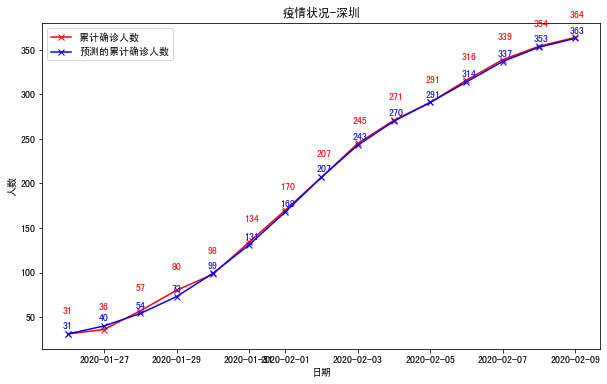

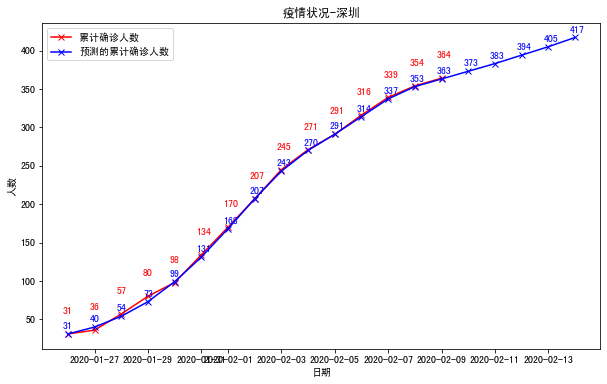

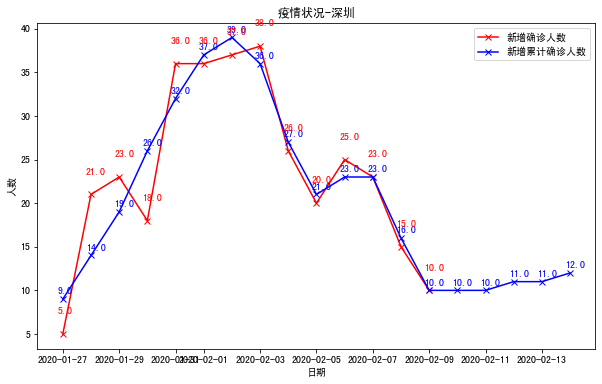

In [211]:
load_model_predict(model_city_date_path, data_sz, city_name='深圳')

In [ ]:
data_wh = merge_data[merge_data.cityname=='武汉']

In [215]:
model_city_date_path = make_dir('wuhan','02-08')
features=['I', 'cured','dead']
I_init = float(data_wh['I'].iloc[0])
R_init = float(data_wh['cured'].iloc[0])
D_init = float(data_wh['dead'].iloc[0])
N = 2870000.
S,I,E,R,D = train(data_wh, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

6208488
Training step:  1565
Loss: 103362.63988520308
Training step:  1566
Loss: 123146.76363365933
Training step:  1567
Loss: 103356.7859153329
Training step:  1568
Loss: 123140.96695097187
Training step:  1569
Loss: 103350.94260521312
Training step:  1570
Loss: 123135.18088403033
Training step:  1571
Loss: 103345.1099249914
Training step:  1572
Loss: 123129.40540296295
Training step:  1573
Loss: 103339.28784494146
Training step:  1574
Loss: 123123.64047804195
Training step:  1575
Loss: 103333.47633546533
Training step:  1576
Loss: 123117.88607965967
Training step:  1577
Loss: 103327.6753670969
Training step:  1578
Loss: 123112.142178348
Training step:  1579
Loss: 103321.88491047894
Training step:  1580
Loss: 123106.40874473142
Training step:  1581
Loss: 103316.10493638078
Training step:  1582
Loss: 123100.68574957317
Training step:  1583
Loss: 103310.33541568823
Training step:  1584
Loss: 123094.97316375287
Training step:  1585
Loss: 103304.57631940536
Training step:  1586
Loss: 1230

In [217]:
model_city_date_path

'models/wuhan/02-08'

[  618   698  1590  1905  2261  2639  3215  4109  5142  6384  8351 10117
 11618 13603 14982]


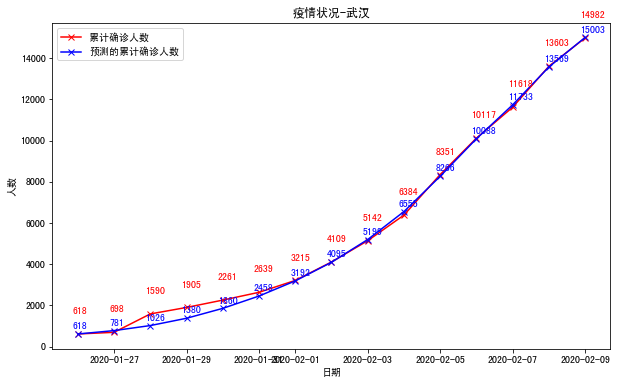

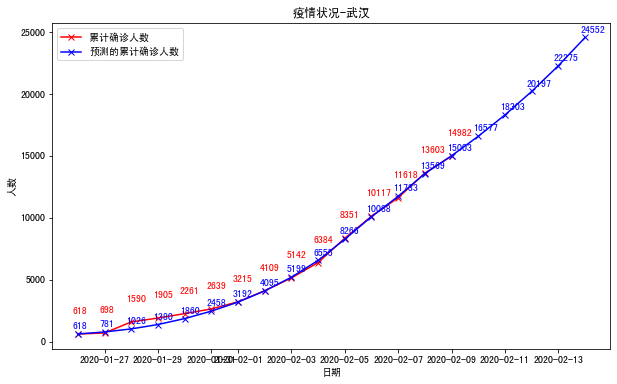

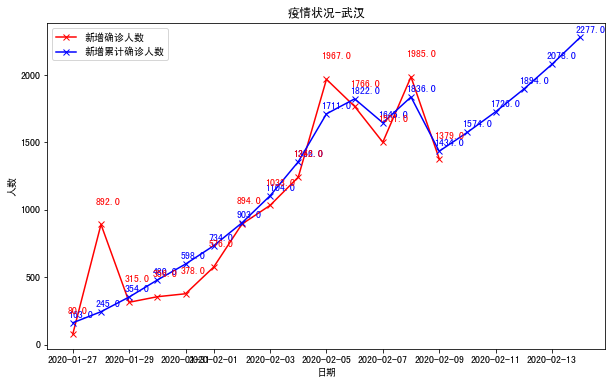

In [224]:
load_model_predict(model_city_date_path, data_wh, city_name='武汉')

In [233]:
def train_with_city_data(data, N, date, cityname='深圳',max_epoches=2000):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    S,I,E,R,D = train(data, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=max_epoches)
    return model_city_date_path

In [226]:
data_hubei = merge_data[(merge_data.provincename=='湖北')&(merge_data.cityname=='全省')]
data_hubei

,provinceid,provincename,cityid,cityname,confirmed,suspected,dead,cured,time,I
0,14,湖北,14.0,全省,45,0,2,0,2020-01-16,43
1,14,湖北,14.0,全省,62,0,2,0,2020-01-17,60
2,14,湖北,14.0,全省,121,0,3,0,2020-01-18,118
3,14,湖北,14.0,全省,198,0,4,0,2020-01-19,194
4,14,湖北,14.0,全省,270,11,6,25,2020-01-20,239
5,14,湖北,14.0,全省,375,0,9,28,2020-01-21,338
6,14,湖北,14.0,全省,444,279,17,28,2020-01-22,399
7,14,湖北,14.0,全省,549,710,24,31,2020-01-23,494
8,14,湖北,14.0,全省,729,1405,39,32,2020-01-24,658
9,14,湖北,14.0,全省,1052,1887,52,42,2020-01-25,958


In [234]:
model_city_date_path = train_with_city_data(data_hubei,59170000.,'02-08','湖北')

555
Loss: 789494.9051515596
Training step:  1556
Loss: 585799.9601185052
Training step:  1557
Loss: 789473.9156442027
Training step:  1558
Loss: 585778.8284523084
Training step:  1559
Loss: 789452.9732614381
Training step:  1560
Loss: 585757.7440730759
Training step:  1561
Loss: 789432.0778401303
Training step:  1562
Loss: 585736.7068170607
Training step:  1563
Loss: 789411.2292177031
Training step:  1564
Loss: 585715.7165212121
Training step:  1565
Loss: 789390.4272323231
Training step:  1566
Loss: 585694.7730232818
Training step:  1567
Loss: 789369.6717230821
Training step:  1568
Loss: 585673.8761619554
Training step:  1569
Loss: 789348.9625299502
Training step:  1570
Loss: 585653.0257764872
Training step:  1571
Loss: 789328.2994932013
Training step:  1572
Loss: 585632.2217069725
Training step:  1573
Loss: 789307.6824544126
Training step:  1574
Loss: 585611.4637944711
Training step:  1575
Loss: 789287.1112558822
Training step:  1576
Loss: 585590.7518806955
Training step:  1577
Loss: 

[   45    62   121   198   270   375   444   549   729  1052  1423  2714
  3554  4586  5806  7153  9074 11177 13522 16678 19665 22112 24953 27100]


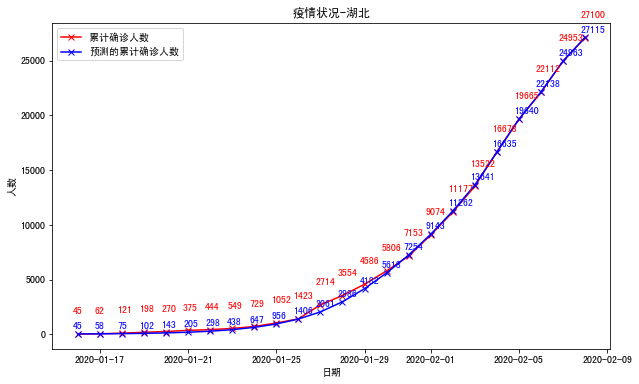

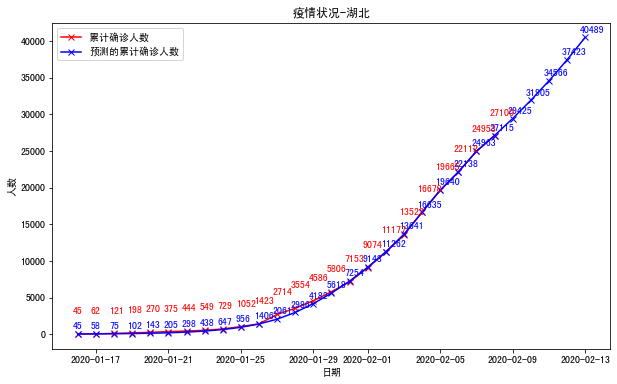

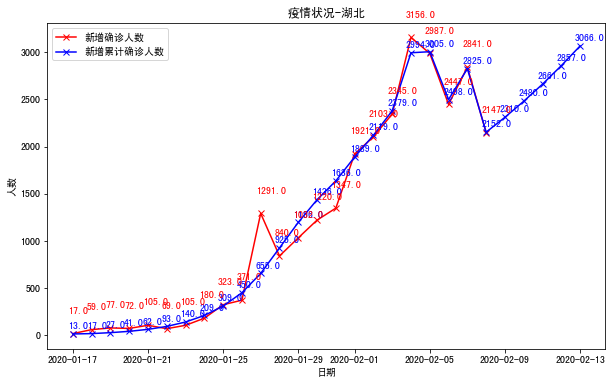

In [235]:
load_model_predict(model_city_date_path, data_hubei, city_name='湖北')

In [270]:
model_city_date_paths = ['models/shenzhen/02-08','models/wuhan/02-08','models/hubei/02-08','models/china/02-08']

In [285]:
for model_i in range(len(model_city_date_paths)):
    print(model_city_date_paths[model_i]+':{')
    model_city_date_path = model_city_date_paths[model_i]
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    beta = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
    print(f'beta_model_{model_i}:{beta}')
    gamma_2 = []
    for i in range(len(model.SEIR_cells)):
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
    print(f'gamma_2_model_{model_i}:{gamma_2}')
    N = []
    for i in range(len(model.SEIR_cells)):
        N.append(model.SEIR_cells[i].N.detach().numpy()[0])
    print(f'N_model_{model_i}:{N}')    
    theta = []
    for i in range(len(model.SEIR_cells)):
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
    print(f'theta_model_{model_i}:{theta}')  
    print('}')

models/shenzhen/02-08:{
beta_model_0:[0.3324570598786039, 0.3660703990998663, 0.37012293866788704, 0.3359298717211147, 0.3472827169183749, 0.2916926663031269, 0.23260457823897654, 0.17689985700009989, 0.11020090691556965, 0.07857826813066872, 0.08717979945181344, 0.07694880791045777, 0.04908076485208502, 0.03143226016260311]
gamma_2_model_0:[0.015766926582741213, 0.0003229684866166613, -0.0014987655783672933, 0.017036119315777476, -0.004872935767061997, 0.008428564616090766, 0.0031920057642101127, 0.018607925019251174, 0.01199709774163275, 0.01149874116802742, 0.01962586077031202, 0.029278446322193518, 0.025746079307347732, -0.0001009110176748631]
N_model_0:[13026599.930272544, 13026599.89081044, 13026599.885829223, 13026599.926342972, 13026599.913921183, 13026599.979148624, 13026600.04285, 13026600.092580827, 13026600.135861713, 13026600.146502743, 13026600.137027169, 13026600.137702012, 13026600.1433252, 13026600.143385228]
E_ratio_model_0:[-0.002928588617922481, -0.01523075376641032

In [275]:
len(model.SEIR_cells)

14

In [280]:
beta_sz = []
for i in range(len(model.SEIR_cells)):
    beta_sz.append(model.SEIR_cells[i].beta.detach().numpy()[0])
beta_sz

[0.3324570598786039,
 0.3660703990998663,
 0.37012293866788704,
 0.3359298717211147,
 0.3472827169183749,
 0.2916926663031269,
 0.23260457823897654,
 0.17689985700009989,
 0.11020090691556965,
 0.07857826813066872,
 0.08717979945181344,
 0.07694880791045777,
 0.04908076485208502,
 0.03143226016260311]